# Import data and libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from scipy.stats import dirichlet

glass_names = ['id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Class']
glass = pd.read_table('Glass Identification/glass.data', sep = ",", names=glass_names)
glass.reindex(index=['id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Class'])
print(glass.head())

   id       RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Class
0   1  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0      1
1   2  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0      1
2   3  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0      1
3   4  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0      1
4   5  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0      1


In [28]:
glass[['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0
...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0


# 檢查是否有Categorical資料與缺失值

In [29]:
# find categorical variables

categorical = [var for var in glass.columns if glass[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

# view the categorical variables if they exist

glass[categorical].head()

There are 0 categorical variables

The categorical variables are :

 []


""
0
1
2
3
4


In [30]:
# 檢查categorical attribute中是否有missing values

glass[categorical].isnull().sum()

Series([], dtype: float64)

In [31]:
# 計算各個 class 的個數
freq = glass['Class'].value_counts()
print(freq)

2    76
1    70
7    29
3    17
5    13
6     9
Name: Class, dtype: int64


# Data Preprocessing

## Ten-bin discretization

In [32]:
X = glass[['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']]
y = glass['Class']

# 對 id 和 class 以外的特徵做 ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

In [33]:
print(X_t[0])

[4. 4. 9. 2. 3. 0. 3. 0. 0.]


In [34]:
print(np.shape(X_t))

(214, 9)


#  Model 1 : Naive Bayesian classifier have Dirichlet priors with the Laplace’s estimate

In [35]:
import scipy.stats
# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [70, 76, 17, 13, 9, 29], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

[[0.38574577 0.32313517 0.0669577  0.04227296 0.0682545  0.1136339 ]]


MultinomialNB(alpha=1,
              class_prior=array([0.38574577, 0.32313517, 0.0669577 , 0.04227296, 0.0682545 ,
       0.1136339 ]))

## 5-Fold cross validation

In [36]:
score = cross_val_score(clf, X_t, y, scoring='accuracy', cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

Means of 5-Fold cross validation: 0.528


## Ranking Attribute by selective naïve Bayes

In [37]:
result = permutation_importance(clf, X_t, y,scoring='accuracy', random_state=0)

print(result.importances_mean)

[0.00841121 0.01495327 0.12523364 0.04299065 0.00654206 0.11495327
 0.00280374 0.06448598 0.03084112]


In [38]:
importances = result.importances_mean

# 把 Attribute 的重要性由大到排序輸出
indices = np.argsort(importances)[::-1]

for i in range(X.shape[1]):
    print('%-10s'%result.importances_mean[indices[i]])

0.12523364485981303
0.11495327102803739
0.06448598130841118
0.04299065420560746
0.030841121495327074
0.014953271028037363
0.008411214953270995
0.0065420560747663226
0.002803738317756976


<function matplotlib.pyplot.show(close=None, block=None)>

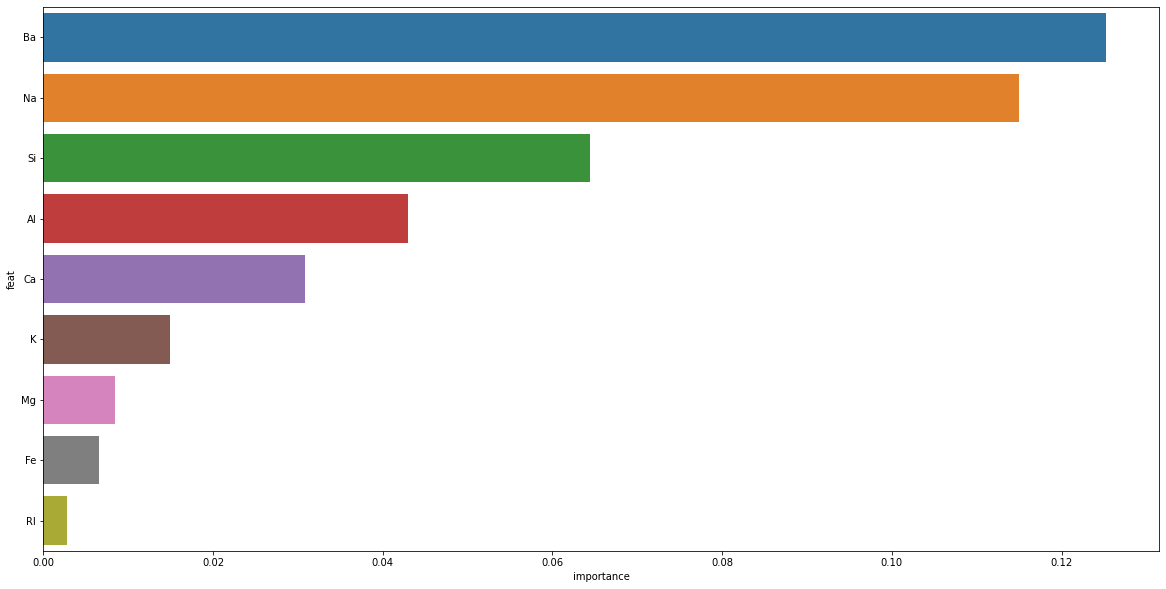

In [39]:
# 視覺化
import seaborn as sns
featImp = pd.DataFrame()
featImp['feat'] = ['Mg', 'K', 'Ba', 'Al', 'Fe', 'Na', 'RI', 'Si', 'Ca']
featImp['importance'] = result.importances_mean
featImp = featImp.sort_values('importance',ascending = False)
plt.figure(figsize=[20,10])
sns.barplot(x = 'importance', y = 'feat',data = featImp[:20], orient='h')
plt.show

## 重新排序特徵

In [40]:
X = glass[['Mg', 'K', 'Ba', 'Al', 'Fe', 'Na', 'RI', 'Si', 'Ca']]
y = glass['Class']

print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring='accuracy', cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

     Mg     K   Ba    Al   Fe     Na       RI     Si    Ca
0  4.49  0.06  0.0  1.10  0.0  13.64  1.52101  71.78  8.75
1  3.60  0.48  0.0  1.36  0.0  13.89  1.51761  72.73  7.83
2  3.55  0.39  0.0  1.54  0.0  13.53  1.51618  72.99  7.78
3  3.69  0.57  0.0  1.29  0.0  13.21  1.51766  72.61  8.22
4  3.62  0.55  0.0  1.24  0.0  13.27  1.51742  73.08  8.07
Means of 5-Fold cross validation: 0.528


#  Model 2 : Naive Bayesian classifier have  the best noninformative Dirichlet priors

In [41]:
X = glass[['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']]
y = glass['Class']

# 對 id 和 class 以外的特徵做 ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

In [42]:
import scipy.stats
d = scipy.stats.dirichlet.rvs(alpha = [1,1,1,1,1,1], size=1, random_state=1)
print(d)

[[2.22110132e-01 5.24449717e-01 4.70811414e-05 1.48186834e-01
  6.53273311e-02 3.98789043e-02]]


In [43]:
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

MultinomialNB(alpha=1,
              class_prior=array([2.22110132e-01, 5.24449717e-01, 4.70811414e-05, 1.48186834e-01,
       6.53273311e-02, 3.98789043e-02]))

In [44]:
score = cross_val_score(clf, X_t, y, scoring='accuracy', cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

Means of 5-Fold cross validation: 0.5


In [45]:
result = permutation_importance(clf, X_t, y,scoring='accuracy', random_state=0)

print(result.importances_mean)

[ 0.00654206  0.00186916  0.12803738  0.04018692  0.00093458  0.0317757
 -0.01028037  0.12897196  0.01682243]


In [46]:
importances = result.importances_mean

# 把 Attribute 的重要性由大到排序輸出
indices = np.argsort(importances)[::-1]

for i in range(X.shape[1]):
    print('%-10s'%result.importances_mean[indices[i]])

0.1289719626168224
0.12803738317757005
0.040186915887850436
0.03177570093457941
0.016822429906542057
0.0065420560747663226
0.0018691588785046287
0.0009345794392523032
-0.010280373831775758


<function matplotlib.pyplot.show(close=None, block=None)>

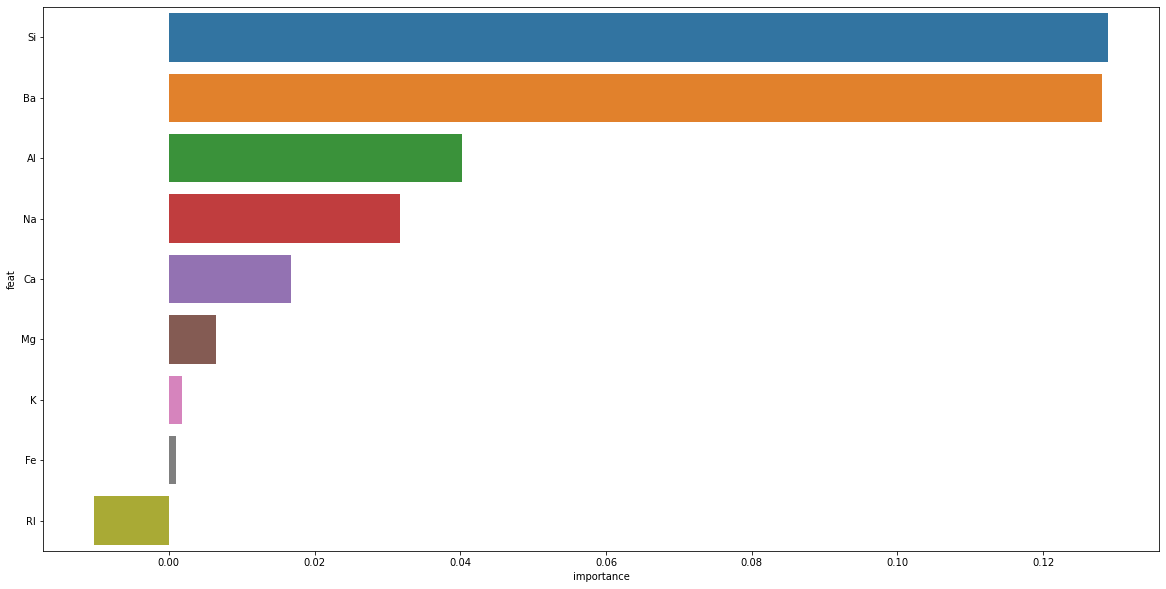

In [47]:
# 視覺化
import seaborn as sns
featImp = pd.DataFrame()
featImp['feat'] = ['Mg', 'K', 'Ba', 'Al', 'Fe', 'Na', 'RI', 'Si', 'Ca']
featImp['importance'] = result.importances_mean
featImp = featImp.sort_values('importance',ascending = False)
plt.figure(figsize=[20,10])
sns.barplot(x = 'importance', y = 'feat',data = featImp[:20], orient='h')
plt.show

In [48]:
X = glass[['Ba', 'Mg', 'Al', 'K', 'Fe', 'RI', 'Na', 'Si']]
y = glass['Class']

# print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

import scipy.stats
d = scipy.stats.dirichlet.rvs(alpha = [1,1,1,1,1,1], size=1, random_state=1)
# print(d)

clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring='accuracy', cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

Means of 5-Fold cross validation: 0.509
